In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("kmean").getOrCreate()
spark

In [2]:
from pyspark.sql.functions import udf

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Window

In [4]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import StringType



In [5]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    # df.toPandas().shape
    print((df.count(), len(df.columns)))

In [6]:
data = spark.read.csv("2019-Oct.csv", 
                      inferSchema=True, 
                      header=True)

In [7]:
new_data = data.withColumn("date_type",F.to_date("event_time"))


In [8]:

rtl_data = new_data\
    .groupBy("event_type")\
    .agg(F.count("user_id").alias("Count"))\
    .withColumn('Total', F.sum('Count').over(Window.partitionBy()))\
    .withColumn('%', (F.col('Count')/F.col('Total'))*100)\
    .sort("Count", ascending=False)

rtl_data.show()

+----------------+-------+-------+------------------+
|      event_type|  Count|  Total|                 %|
+----------------+-------+-------+------------------+
|            view|1862164|4102283|45.393357796134495|
|            cart|1232385|4102283|30.041442777107285|
|remove_from_cart| 762110|4102283|18.577704171067673|
|        purchase| 245624|4102283| 5.987495255690551|
+----------------+-------+-------+------------------+



In [9]:
rtl_data = new_data.filter(F.col("event_type") == "purchase")

#rtl_data = rtl_data.filter(F.col("user_session").isNotNull())
#rtl_data = rtl_data.filter(F.col("category_code").isNotNull())
#rtl_data = rtl_data.filter(F.col("brand").isNotNull())


In [10]:
nullcount(rtl_data)

{'event_time': 0,
 'event_type': 0,
 'product_id': 0,
 'category_id': 0,
 'category_code': 242331,
 'brand': 100697,
 'price': 0,
 'user_id': 0,
 'user_session': 0,
 'date_type': 0}

In [11]:
rtl_data.select(F.max('date_type')).collect()

[Row(max(date_type)=datetime.date(2019, 10, 31))]

In [12]:
# Recency   = Overall latest invoice date - individual customer's last invoice date
# Frequency = count of invoice no. of transaction(s)
# Monetary = Sum of Total amount for each customer

# to calculate recency in days.
latest_date = F.to_date(F.lit("2019-11-01"), 'yyyy-MM-dd')

# Create RFM Modelling scores for each customer

rfm_scores = (rtl_data.groupBy("user_id")
              .agg((F.datediff(latest_date, F.max(F.col("date_type")))).alias("Recency"),
                   F.count("*").alias("Frequency"),
                   F.sum(F.col("price")).alias("Monetary")).sort("user_id"))


rfm_scores.show()

+--------+-------+---------+------------------+
| user_id|Recency|Frequency|          Monetary|
+--------+-------+---------+------------------+
|29025780|     25|       18|             41.68|
|31229488|     29|        4|             14.43|
|33535391|     19|       11|            138.88|
|33609704|     17|        9|31.309999999999995|
|34080306|      2|        3|             16.75|
|35376580|      2|        2|             10.89|
|37189384|      2|        7|18.330000000000002|
|40168534|      9|        3|             11.34|
|40821287|     29|       20|             34.71|
|41738010|     28|        3|21.060000000000002|
|43713532|     19|       56|228.10000000000005|
|45437953|     19|       10|              77.1|
|47076222|      7|        9|25.160000000000004|
|48273884|      8|        8|             42.56|
|49280814|     17|        9|             47.84|
|50142794|     18|        5|             19.71|
|50320281|     29|        4|23.650000000000002|
|50764735|      9|       11|147.44000000

In [12]:
rfm_scores.describe().show()

+-------+-------------------+------------------+------------------+-------------------+
|summary|            user_id|           Recency|         Frequency|           Monetary|
+-------+-------------------+------------------+------------------+-------------------+
|  count|              25762|             25762|             25762|              25762|
|   mean|4.975684332601894E8|15.659692570452604| 9.534352922909711|  47.02812009937134|
| stddev|8.572289165031126E7| 8.969810190157334|11.341404847074877|  55.69722892538612|
|    min|           29025780|                 1|                 1|-3.0200000000000156|
|    max|          566274213|                31|               329| 1295.4800000000002|
+-------+-------------------+------------------+------------------+-------------------+



In [13]:
rfm_scores_df = rfm_scores.toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

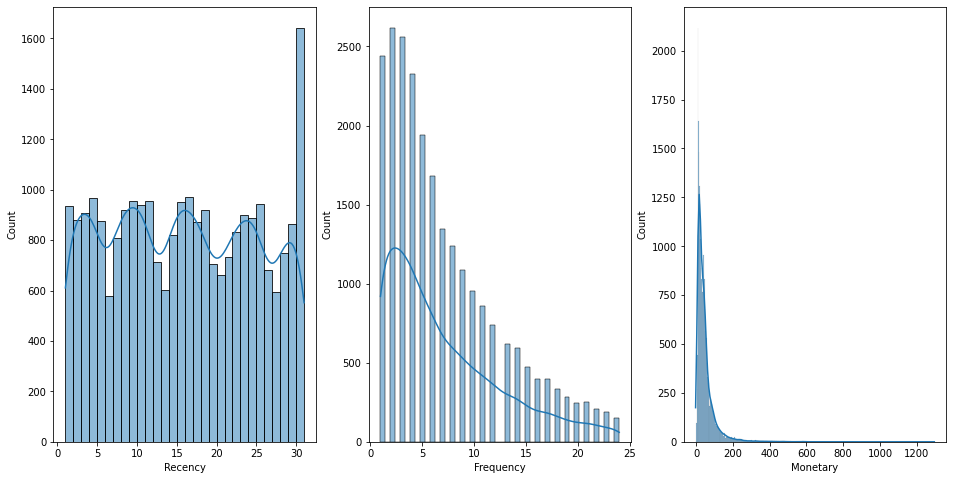

In [14]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(rfm_scores_df['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_scores_df.query('Frequency < 25')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_scores_df.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

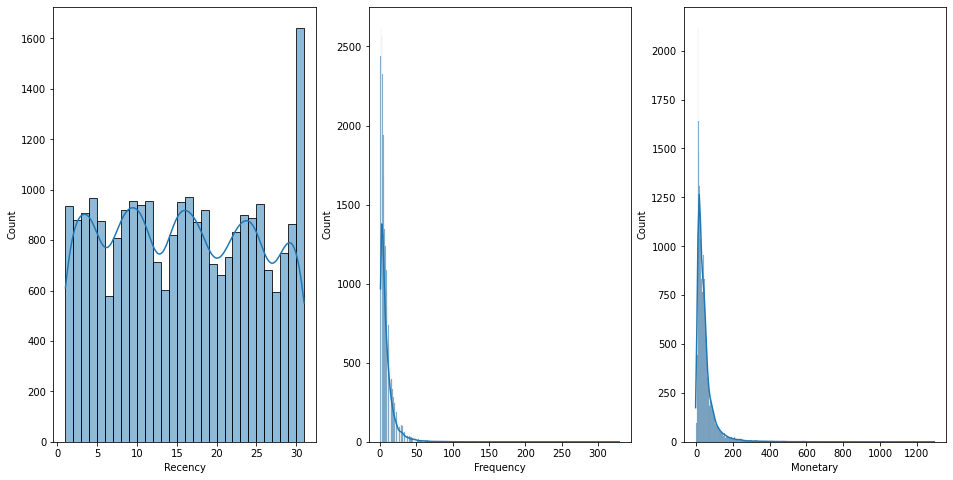

In [15]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(rfm_scores_df['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_scores_df['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_scores_df['Monetary'], kde=True, ax=ax[2])

In [15]:
# Since log transformation doesn't work with negative and zero values, lets get rid of negative and zeros

rfm_data = (
    rfm_scores.withColumn(
        "Monetary", 
        F.when(F.col("Monetary") <= 0, 1)
         .otherwise(F.col("Monetary")))
)



In [16]:
features = rfm_data.columns[1:]

rfm_data.show()

+--------+-------+---------+------------------+
| user_id|Recency|Frequency|          Monetary|
+--------+-------+---------+------------------+
|29025780|     25|       18|             41.68|
|31229488|     29|        4|             14.43|
|33535391|     19|       11|            138.88|
|33609704|     17|        9|31.309999999999995|
|34080306|      2|        3|             16.75|
|35376580|      2|        2|             10.89|
|37189384|      2|        7|18.330000000000002|
|40168534|      9|        3|             11.34|
|40821287|     29|       20|             34.71|
|41738010|     28|        3|21.060000000000002|
|43713532|     19|       56|228.10000000000005|
|45437953|     19|       10|              77.1|
|47076222|      7|        9|25.160000000000004|
|48273884|      8|        8|             42.56|
|49280814|     17|        9|             47.84|
|50142794|     18|        5|             19.71|
|50320281|     29|        4|23.650000000000002|
|50764735|      9|       11|147.44000000

In [17]:
assembler = VectorAssembler(
    inputCols=features, 
    outputCol="rfm_features")

assembled_data = assembler.transform(rfm_data)

assembled_data = assembled_data.select('user_id', 'rfm_features')

assembled_data.show()

+--------+--------------------+
| user_id|        rfm_features|
+--------+--------------------+
|29025780|   [25.0,18.0,41.68]|
|31229488|    [29.0,4.0,14.43]|
|33535391|  [19.0,11.0,138.88]|
|33609704|[17.0,9.0,31.3099...|
|34080306|     [2.0,3.0,16.75]|
|35376580|     [2.0,2.0,10.89]|
|37189384|[2.0,7.0,18.33000...|
|40168534|     [9.0,3.0,11.34]|
|40821287|   [29.0,20.0,34.71]|
|41738010|[28.0,3.0,21.0600...|
|43713532|[19.0,56.0,228.10...|
|45437953|    [19.0,10.0,77.1]|
|47076222|[7.0,9.0,25.16000...|
|48273884|     [8.0,8.0,42.56]|
|49280814|    [17.0,9.0,47.84]|
|50142794|    [18.0,5.0,19.71]|
|50320281|[29.0,4.0,23.6500...|
|50764735|[9.0,11.0,147.440...|
|52747911|    [22.0,3.0,23.02]|
|53111013|     [24.0,1.0,20.0]|
+--------+--------------------+
only showing top 20 rows



In [18]:
scaler = StandardScaler(inputCol='rfm_features', outputCol='features')

data_scale = scaler.fit(assembled_data)

scaled_data = data_scale.transform(assembled_data)

scaled_data.show()

+--------+--------------------+--------------------+
| user_id|        rfm_features|            features|
+--------+--------------------+--------------------+
|29025780|   [25.0,18.0,41.68]|[2.78712698150879...|
|31229488|    [29.0,4.0,14.43]|[3.23306729855019...|
|33535391|  [19.0,11.0,138.88]|[2.11821650594668...|
|33609704|[17.0,9.0,31.3099...|[1.89524634742597...|
|34080306|     [2.0,3.0,16.75]|[0.22297015852070...|
|35376580|     [2.0,2.0,10.89]|[0.22297015852070...|
|37189384|[2.0,7.0,18.33000...|[0.22297015852070...|
|40168534|     [9.0,3.0,11.34]|[1.00336571334316...|
|40821287|   [29.0,20.0,34.71]|[3.23306729855019...|
|41738010|[28.0,3.0,21.0600...|[3.12158221928984...|
|43713532|[19.0,56.0,228.10...|[2.11821650594668...|
|45437953|    [19.0,10.0,77.1]|[2.11821650594668...|
|47076222|[7.0,9.0,25.16000...|[0.78039555482246...|
|48273884|     [8.0,8.0,42.56]|[0.89188063408281...|
|49280814|    [17.0,9.0,47.84]|[1.89524634742597...|
|50142794|    [18.0,5.0,19.71]|[2.006731426686

In [19]:
dense_vector = scaled_data.select("features").collect()[0] #trial

In [26]:
((dense_vector-centers[0])**2).sum()

1.0903750315850513

In [44]:
#intra cluster distance
def distance(x,centroid): 
    distances = []
    for center in centroid:
        d = ((np.array(x) - center)**2).sum()
        distances.append(d)
    return min(distances)

In [28]:
for j in dense_vector:   #.squared_distance(centers[0])
    print(j)

[2.7871269815087905,1.5871049700375064,0.74833565141616]


In [65]:
print(dense_vector[0])

[2.7871269815087905,1.5871049700375064,0.74833565141616]


In [60]:
from pyspark.ml.linalg import DenseVector

In [31]:
scaled_data_df = scaled_data.toPandas()

In [32]:
scaled_data_df

,user_id,rfm_features,features
0,29025780,"[25.0, 18.0, 41.68]","[2.7871269815087905, 1.5871049700375064, 0.748..."
1,31229488,"[29.0, 4.0, 14.43]","[3.2330672985501967, 0.35268999334166806, 0.25..."
2,33535391,"[19.0, 11.0, 138.88]","[2.118216505946681, 0.9698974816895871, 2.4934..."
3,33609704,"[17.0, 9.0, 31.309999999999995]","[1.8952463474259775, 0.7935524850187532, 0.562..."
4,34080306,"[2.0, 3.0, 16.75]","[0.22297015852070323, 0.26451749500625105, 0.3..."
...,...,...,...
25757,566264460,"[1.0, 6.0, 9.74]","[0.11148507926035162, 0.5290349900125021, 0.17..."
25758,566270279,"[1.0, 6.0, 32.74]","[0.11148507926035162, 0.5290349900125021, 0.58..."
25759,566270544,"[1.0, 1.0, 19.84]","[0.11148507926035162, 0.08817249833541702, 0.3..."
25760,566272734,"[1.0, 7.0, 10.79]","[0.11148507926035162, 0.617207488347919, 0.193..."


In [39]:
scaled_data_df['centroid_distance'] = scaled_data_df['features'].apply(distance)

In [37]:
np.array(scaled_data_df['features'].loc[0])

array([2.78712698, 1.58710497, 0.74833565])

In [30]:
scaled_data.withColumn('result', distance(scaled_data.features))


DataFrame[user_id: int, rfm_features: vector, features: vector, result: double]

In [41]:
scaled_data.select('features').show()

+--------------------+
|            features|
+--------------------+
|[2.78712698150879...|
|[3.23306729855019...|
|[2.11821650594668...|
|[1.89524634742597...|
|[0.22297015852070...|
|[0.22297015852070...|
|[0.22297015852070...|
|[1.00336571334316...|
|[3.23306729855019...|
|[3.12158221928984...|
|[2.11821650594668...|
|[2.11821650594668...|
|[0.78039555482246...|
|[0.89188063408281...|
|[1.89524634742597...|
|[2.00673142668632...|
|[3.23306729855019...|
|[1.00336571334316...|
|[2.45267174372773...|
|[2.67564190224843...|
+--------------------+
only showing top 20 rows



In [21]:


# Trains a k-means model.

kmeans = KMeans(featuresCol = 'features', k=4)
model = kmeans.fit(scaled_data)


In [22]:
pred = model.transform(scaled_data)
#pred.show()

In [23]:
evaluator = ClusteringEvaluator()

In [24]:
silhouette = evaluator.evaluate(pred)
print("Silhouette with squared euclidean distance: " + str(silhouette))

Silhouette with squared euclidean distance: 0.5903553680604866


In [25]:
# Shows the result, cluster centers
centers = model.clusterCenters()
print(centers)

[array([2.62345375, 0.56827043, 0.58845352]), array([1.37996775, 5.82798709, 6.43992645]), array([0.8784312 , 0.56334339, 0.57663865]), array([1.4216438 , 2.23831398, 2.08775188])]


In [47]:
#distortion calculation
distortion = []
for k in range(2,10):
    kmeans = KMeans(featuresCol = 'features', k=k)
    model = kmeans.fit(scaled_data)
    pred = model.transform(scaled_data).toPandas()
    centers = model.clusterCenters()
    print(centers)
    pred['centroid_distance'] = pred['features'].apply(lambda x: distance(x,centers))
    intra = pred.groupby('prediction')['centroid_distance'].sum().sum()
    distortion.append(intra)

[array([1.35795213, 3.00134207, 2.95219183]), array([1.78583314, 0.61778139, 0.62692873])]
[array([2.62341772, 0.6165972 , 0.63401071]), array([1.39780306, 3.37593868, 3.33419856]), array([0.89924649, 0.69040309, 0.68685684])]
[array([2.62345375, 0.56827043, 0.58845352]), array([1.37996775, 5.82798709, 6.43992645]), array([0.8784312 , 0.56334339, 0.57663865]), array([1.4216438 , 2.23831398, 2.08775188])]
[array([2.36274659, 1.35110387, 1.27511309]), array([1.09659403, 2.56012096, 2.40537278]), array([0.8640067 , 0.56335943, 0.57561383]), array([2.64723631, 0.41392063, 0.45793212]), array([1.39598708, 6.21009129, 6.75866721])]
[array([2.52410088, 1.37095225, 1.29717794]), array([0.8403167 , 1.75690643, 1.57795103]), array([0.88593318, 0.47759322, 0.50743138]), array([2.62377983, 0.41428611, 0.45888292]), array([1.35679713, 7.42274862, 8.30555696]), array([1.44285648, 3.57114233, 3.55969002])]
[array([2.60422809, 1.30627503, 1.19301176]), array([1.36234767, 3.68649216, 2.64467309]), arra

In [51]:
# silhouette score for knee points
for k in range(3,6):
    kmeans = KMeans(featuresCol = 'features', k=k)
    model = kmeans.fit(scaled_data)
    pred = model.transform(scaled_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(pred)
    print("Silhouette with squared euclidean distance = " , silhouette)


Silhouette with squared euclidean distance =  0.5619662504140445
Silhouette with squared euclidean distance =  0.5903553680604866
Silhouette with squared euclidean distance =  0.5453934465041523


In [ ]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

In [48]:
print(distortion)

[52669.486587352694, 35107.07094915601, 27139.31991593322, 24264.82237304522, 21583.432205579098, 19907.848278330675, 17399.635060234665, 16475.856911479324]


Text(0, 0.5, 'distortion')

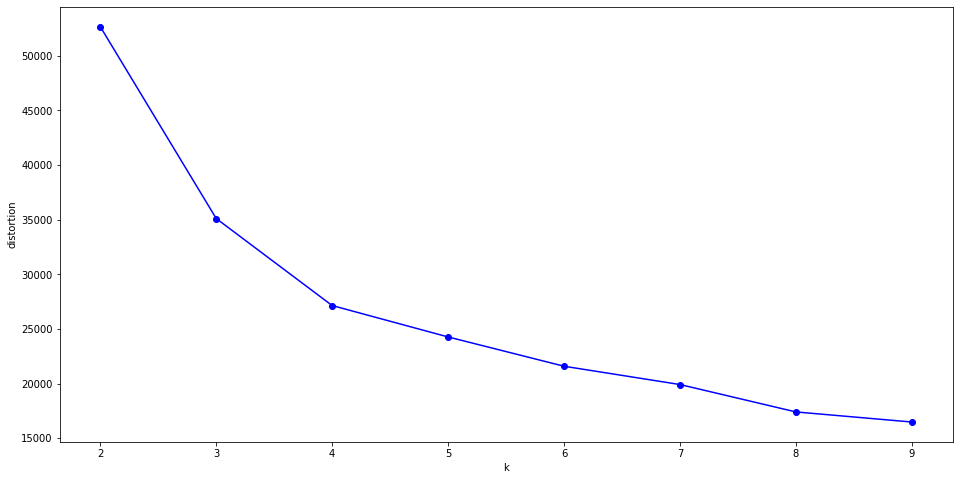

In [49]:
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot( list(range(2,10)),distortion,'-ob')
ax.set_xlabel('k')
ax.set_ylabel('distortion')

Text(0, 0.5, 'distortion')

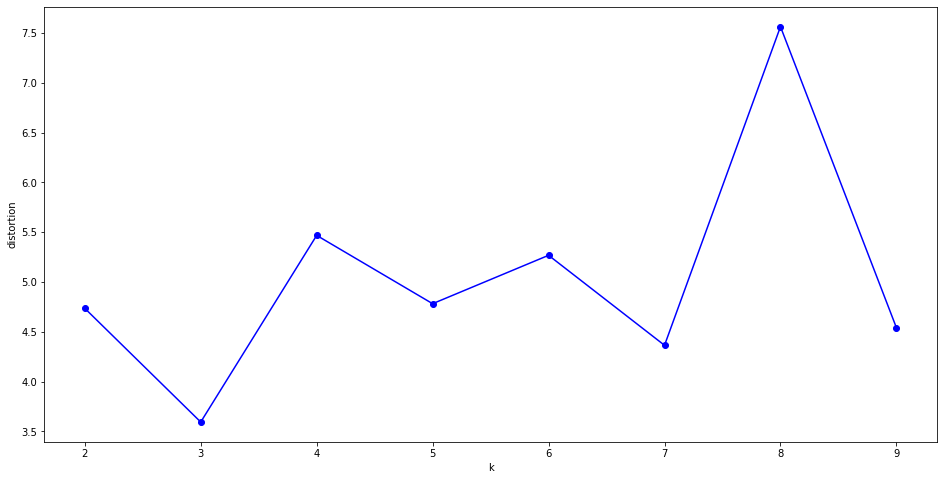

In [42]:
#failed attempt using mean
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot(distortion.keys(), distortion.values(),'-ob')
ax.set_xlabel('k')
ax.set_ylabel('distortion')

Text(0, 0.5, 'cost')

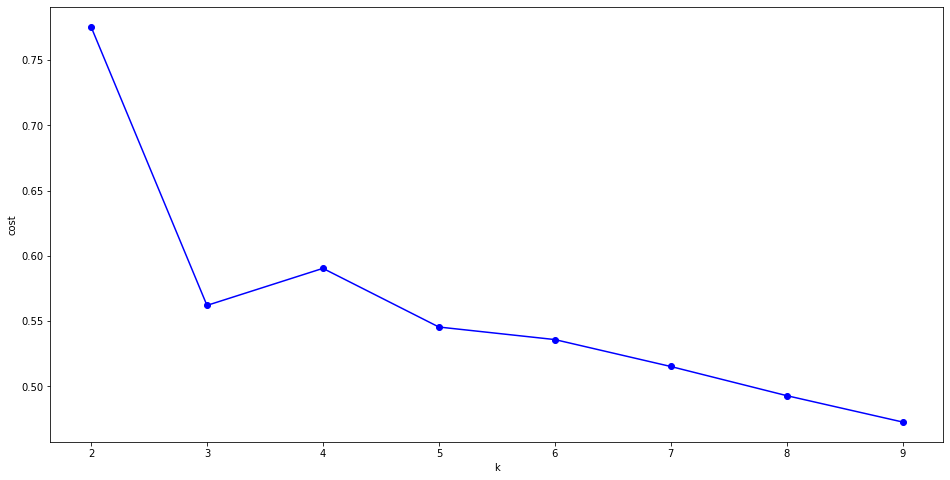

In [40]:
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot(costs.keys(), costs.values(),'-ob')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [50]:
result = pred.select('user_id', 'prediction')
result.show()

+--------+----------+
| user_id|prediction|
+--------+----------+
|29025780|         0|
|31229488|         0|
|33535391|         3|
|33609704|         0|
|34080306|         2|
|35376580|         2|
|37189384|         2|
|40168534|         2|
|40821287|         0|
|41738010|         0|
|43713532|         1|
|45437953|         0|
|47076222|         2|
|48273884|         2|
|49280814|         0|
|50142794|         0|
|50320281|         0|
|50764735|         3|
|52747911|         0|
|53111013|         0|
+--------+----------+
only showing top 20 rows



In [51]:
# Join other information with the prediction result-set

rfm_score = spark.read.csv('loyalty_rfm.csv', 
                           inferSchema=True, 
                           header=True)
rfm_score = rfm_score.select("user_id", "Recency", "Frequency", "Monetary", "RFM_Score", "RFM_ScoreGroup", "Loyalty")



In [52]:
combined_result = result.join(rfm_score, on='user_id', how='inner')


In [53]:
combined_result.show()

+--------+----------+-------+---------+------------------+---------+--------------+--------+
| user_id|prediction|Recency|Frequency|          Monetary|RFM_Score|RFM_ScoreGroup| Loyalty|
+--------+----------+-------+---------+------------------+---------+--------------+--------+
|29025780|         0|     25|       32| 43.24000000000001|        5|           311|Platinum|
|31229488|         0|     29|       32|            548.77|        5|           311|Platinum|
|33535391|         3|     19|       27|304.59999999999997|        4|           211|Platinum|
|33609704|         0|     16|       47|            159.44|        4|           211|Platinum|
|34080306|         2|      1|       39|208.76000000000008|        3|           111|Platinum|
|35376580|         2|      2|        5|             43.35|        3|           111|Platinum|
|37189384|         2|      2|       15|35.589999999999996|        4|           112|Platinum|
|40168534|         2|      9|        4|              8.24|        5|  

In [54]:
pred.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  328|
|         3| 3188|
|         2|10526|
|         0|11720|
+----------+-----+



In [55]:
combined_result_df = combined_result.toPandas()

combined_result_df.to_csv('combined_result_k9.csv', index=False)

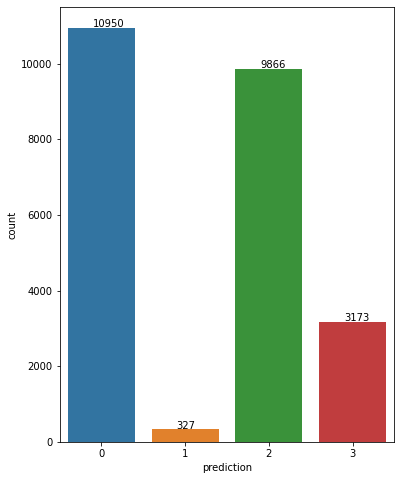

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

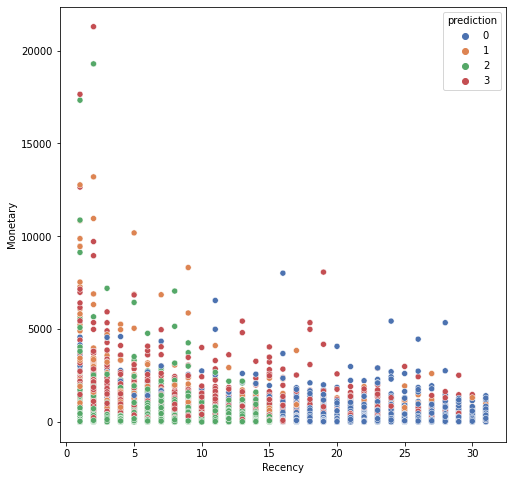

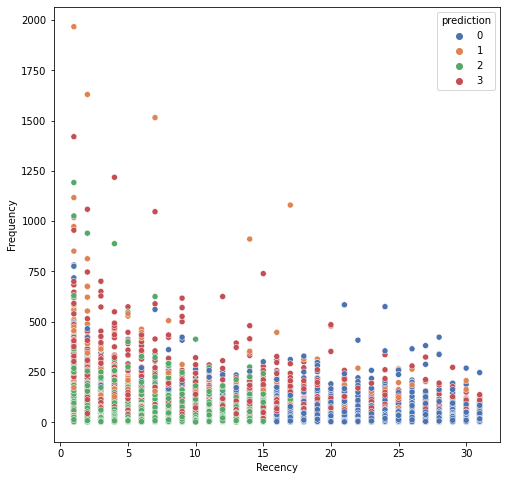

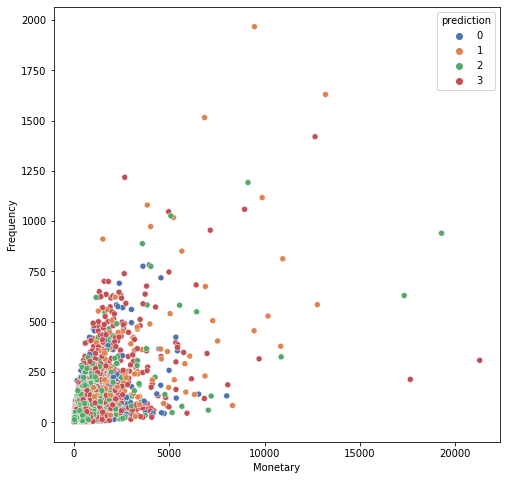

In [57]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")